In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, HTML
import pandas as pd
from sklearn.metrics import confusion_matrix
import mne
import os.path as op

from __future__ import print_function
from __future__ import division
import keras
from keras.models import load_model
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
import seaborn as sns


from keras.optimizers import RMSprop

import random
SEED = 3

/anaconda3/envs/EEGProject/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [70]:
#read function, returning a object of class 'raw'
def read(file):
   # channels = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4']
    channels =  ['FC6'] #, 'P8', 'FC6', 'F4', 'F8', 'AF4']
   # channels = ['F7']#, 'F3', 'FC5', 'P7' ,'O1' ,'O2', 'P8', 'FC6', 'F4', 'T7', 'F8']
    raw_file = mne.io.read_raw_edf('data/%s.edf'%(file), preload = True, verbose = 0)
    raw_file.filter(1,None, fir_design='firwin')
    
    raw_file.notch_filter(50, notch_widths=2,fir_design='firwin')
    return raw_file.pick_channels(channels)
    
def read_markers(file):
    raw_file = mne.io.read_raw_edf('data/%s.edf'%(file), preload = True)
    return raw_file[20]

#plotting functions

    
def create_events_sound(markers):
    
    event_id = 2
    class_nb_1 = 0 
    class_nb_2 = 1
    markers = (markers.ravel())*(1000000) # flatten and rescale marker file
    
    start = 0 
    events_time = []  # list to store the time of the events
    class_nb_list = [] # # list to store the class number
    for i in np.arange(0,len(markers)):
        if (markers[i]) == event_id:
            start = i
            print('starttime = ', start )
           
        
    for k in np.arange(start+384,(start+384+(199*384)), 384):
        events_time.append(k)
        class_nb_list.append(class_nb_1)  
       # to take samples of blank data from between bleeps:  
    for j in np.arange(start+192,(start+192+(199*384)), 384): #(99*384)
        events_time.append(j)
        class_nb_list.append(class_nb_2)
           
        # to take blank samples from after the sound file sound_10_min
           # for j in np.arange(84480,(84480+(199*116)), 116):
           #     events_time.append(j)
           #     class_nb_list.append(class_nb_1)
           # print(len(events_time))
            
       #  to take blank samples from after the sound file sound_3
        #    for j in np.arange(99840,(99840+(199*116)), 116):
        #        events_time.append(j)
        #        class_nb_list.append(class_nb_1)
        #    print(len(events_time))
        #  
            
                
        #    print(len(events_time))
           
    previous_marker_value = np.zeros(len(events_time)) # list with previous id, required to create Epoch object
    events = np.column_stack((events_time, previous_marker_value, class_nb_list))
    events = events.astype(int)
    events = events[np.argsort(events[:,0])]
    return (events)

def create_events_move_left_right(markers, event_id_1, event_id_2):
    
    class_nb_1 = event_id_1 - 3 # change to binary values. 
    class_nb_2 = event_id_2 - 3
    markers = (markers.ravel())*(1000000) # flatten and rescale marker file
    
    events_time = []  # list to store the time of the events
    class_nb_list = [] # # list to store the class number
    for i in np.arange(0,len(markers)):
        if (markers[i]) == event_id_1:
            events_time.append(i)
            class_nb_list.append(class_nb_1)
        if (markers[i]) == event_id_2:
            events_time.append(i)
            class_nb_list.append(class_nb_2)   
    

    previous_marker_value = np.zeros(len(events_time)) # list with previous id, required to create Epoch object
    
    events = np.column_stack((events_time, previous_marker_value, class_nb_list))
    events = events.astype(int)
    events = events[np.argsort(events[:,0])]
  #  onlyleft = np.arange(1,len(events),2)
  #  events = np.delete(events,onlyleft, axis = 0 )
  #  for i in np.arange(0,len(events),2):    
  #      events[i,2]=1
   # events = events[:12]
  
    return (events)

def create_events_blinks(markers):
    
    event_id_1 = 2  # event_id blinks
    event_id_2 = 3  # event_id blanks
    class_nb_1 = event_id_1 - 2 # change to binary values. 
    class_nb_2 = event_id_2 - 2
    markers = (markers.ravel())*(1000000) # flatten and rescale marker file to order 1
    
    events_time = []  # list to store the time of the events
    class_nb_list = [] # # list to store the class number
    for i in np.arange(0,len(markers)):
        if (markers[i]) == event_id_1:
            events_time.append(i)
            class_nb_list.append(class_nb_1)
        if (markers[i]) == event_id_2:
            events_time.append(i)
            class_nb_list.append(class_nb_2)   
    
  
    previous_marker_value = np.zeros(len(events_time)) # list with previous id, required to create Epoch object
    
    events = np.column_stack((events_time, previous_marker_value, class_nb_list))
    events = events.astype(int)
    events = events[np.argsort(events[:,0])]  # sort on time of events, just to prevent repeating warning message 
  
   # remove hand picked bad events if neccessary  
   # bad = np.array([5,9, 28, 29,43, 44, 45,59, 61])
   # events = np.delete(events,bad, axis = 0 )
    
    events_stream = events[:11]
    print(events_stream)
    events = events[11:]
    print (events[:4])
    return (events)

############################################################

def create_events_move_single(markers):
    
    event_id_1 = 2
    class_nb_1 = event_id_1 - 2 # change to binary values. 
    class_nb_2 = event_id_1 - 1
    markers = (markers.ravel())*(1000000) # flatten and rescale marker file
    
    events_time = []  # list to store the time of the events
    class_nb_list = [] # # list to store the class number
    for i in np.arange(0,len(markers)):
        if (markers[i]) == event_id_1:
            events_time.append(i)
            class_nb_list.append(class_nb_1)
    for j in np.arange(115500,(115500+(152*128)), 128):
                events_time.append(j)
                class_nb_list.append(class_nb_2)
        
    #for j in np.arange(0,76):
     #   class_nb_list[j] = 1
   
    
    
    previous_marker_value = np.zeros(len(events_time)) # list with previous id, required to create Epoch object
    
    events = np.column_stack((events_time, previous_marker_value, class_nb_list))
    events = events.astype(int)
    events = events[np.argsort(events[:,0])]
    return (events)


def create_epochs(raw_file, events,make_psd, tmin, tmax, proj, apply_savgol,
                  split_channels, noise_value, print_cleaning):
   
    if(make_psd):
        x_train, freqs_blinks = mne.time_frequency.psd_multitaper(x_train,fmin=10, fmax=20, n_jobs=1)
    
    else:
        x_train = mne.Epochs(raw_file, events=events, tmin=tmin,
                                tmax=tmax, preload = True, verbose = False)
    
    
    if(apply_savgol):
        x_train.savgol_filter(5.)
    
    
    y_train = np.array(events[:,2]) # create labels
    
    
    if (split_channels):
        x_train = np.array(x_train) # convert epoch object to numpy array.
        x_train_temp = []
        y_train_temp = []
        nb_channels = x_train.shape[1]
        print ("channels = " , nb_channels)
        for j in np.arange(len(x_train)): 
            for k in np.arange(nb_channels):
                x_train_temp.append(x_train[j][k])
                y_train_temp.append(y_train[j])
    
        # convert lists to arrays
        x_train = np.array(x_train_temp)
        y_train = np.array(y_train_temp)
        
        # rescaling, so values are in range of initial weights
        x_train = x_train *100000
        
        # clean data from noise
        if (print_cleaning):
            print('samples before clean:' , len(x_train))
        index = []
        for i in np.arange(len(x_train)): 
            for j in np.arange(len(x_train[i])):
                if (abs(x_train[i][j]) > noise_value):
                    index.append(i)
        x_train = np.delete(x_train, index, 0)
        y_train = np.delete(y_train,index)
        if (print_cleaning):
            print('samples after clean:' , len(x_train))
  
    # put noise here!
    else:
        # clean data from noise
        x_train = np.array(x_train) # convert epoch object to numpy array.
        # rescaling, so values are in range of initial weights
        x_train = x_train *100000
        print('samples before clean:' , len(x_train))
        index = []
        for i in np.arange(len(x_train)):
            if (x_train[i].max() > noise_value):
                index.append(i)
        x_train = np.delete(x_train, index, 0)
        y_train = np.delete(y_train,index)
        print('samples after clean:' , len(x_train))
                
        
 #  x_train = x_train.reshape(x_train.shape[0],x_train.shape[2])

  
   
    x_train = np.array(x_train)
    # shuffle the channels, before dividing into train and test set.     
    np.random.seed(SEED)
    np.random.shuffle(x_train)
    np.random.seed(SEED)
    np.random.shuffle(y_train)
   # np.random.shuffle(y_train)

  
    #split in test and trainset:
    split = int((len(x_train)) *0.8)
    x_test_split = x_train[split:]
    x_train_split = x_train[:split]
    y_test_split = y_train[split:]
    y_train_split = y_train[:split]
                 
    return (x_train_split, y_train_split),(x_test_split, y_test_split)



class Histories(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
 
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))
        return
 
# Function that displays confusion matrix
def dispMat(x):
    display(pd.DataFrame(x, index = digits, columns = digits))


# Produce a list filled with the confusion matrixes of all the individual channels. 
def make_conf_matrix(channels, events, show_matrix):
    
    digits = [0,1]
    pick = []
    conf_matrix_list = []
    train_accuracy = []
    test_accuracy = []
    models_list = []


    batch_size = 2
    epochs = 10

    split_channels = True
    for pick in np.arange(len(channels)):


        channel = channels[pick]

        channel = ['%s'%(channel)]  # convert to string
        raw = read(file = file_name) 

        temp_file = raw.pick_channels(channel)

      #  events = create_events_move(markers)

        (x_train, y_train), (x_test, y_test) = create_epochs(temp_file, events = events, tmin =tmin,tmax=tmax,
                                                             proj = proj, make_psd = make_psd, 
                                                             apply_savgol= apply_savgol, 
                                                             split_channels = split_channels,
                                                             noise_value= noise_value, 
                                                             print_cleaning = False)

      #  print("Labels to predict before equal:" , len(y_test))
        
        # make sure there are equal samples of both events.
        biggest = 0
        if (sum(y_test == 0) < sum(y_test == 1)):
            biggest = 1
        diff = abs(sum(y_test == 0) - sum(y_test == 1))
        index = np.array(np.where(y_test == biggest)) 
        index = index.reshape(index.shape[1])
        index = index[:diff] 
        y_test = np.delete(y_test,index)
        x_test = np.delete(x_test,index, 0)
      #  print("Labels to predict after equal:" , len(y_test))

        #feed samples to double layer perceptron 
        model = Sequential()
        model.add(Dense(64, activation='relu', input_shape=(129,)))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0,
                 validation_data=(x_test, y_test))

        
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test accuracy:', score[1])

        y_predict = model.predict_classes(x_test)
        conf_matrix_list.append(confusion_matrix(y_predict, y_test))
        models_list.append(model)
        if(show_matrix):
            dispMat(conf_matrix_list[pick])
        
    split_channels = False

    (x_train, y_train), (x_test, y_test) = create_epochs(raw_file, events = events, tmin =tmin,tmax=tmax,
                                                     proj = proj, make_psd = make_psd, 
                                                     apply_savgol= apply_savgol, 
                                                     split_channels = split_channels,
                                                     noise_value= noise_value, 
                                                     print_cleaning = False)

    print ('shape x_test' ,x_test.shape)
    print ('shape y_test' ,x_test.shape)


    prediction_events = []


    for i in np.arange(0,len(x_test)):
        x_test_single = x_test[i]

        prediction_event_channel = []
        for j in np.arange(0,len(channels)):
            pick_channel = x_test_single[j]
            pick_channel = pick_channel.reshape(1,len(pick_channel))
            prediction_pick_channel = models_list[j].predict_classes(pick_channel)
            prediction_event_channel.append(prediction_pick_channel)  
        prediction_events.append(prediction_event_channel)
    prediction_events = np.array(prediction_events)
    prediction_events = prediction_events.reshape(len(x_test),len(channels)).T
    
    labels = y_test
    print("Labels to predict:" , len(y_test))
    
    #calculate probabilities from confusion matrixes.
    certainty_events = []

    for i in np.arange(0, len(prediction_events[0])): # for all events
        pick_event = prediction_events[:,i]
        probabilities = []
        one_min_prob = []

        # calculate probability:
        for ch in np.arange(0,len(pick_event)): # for all channels
            conf_matrix = conf_matrix_list[ch]
            if(pick_event[ch]==0):
                probabilities.append(conf_matrix[0,0]/(np.sum(conf_matrix[0])))
            else:
                probabilities.append(conf_matrix[1,0]/(np.sum(conf_matrix[1])))
            one_min_prob.append(1-probabilities[ch])

        certainty = np.prod(probabilities)/(np.prod(probabilities)+np.prod(one_min_prob))
        certainty_events.append(certainty)

   #  print ('certainty events =' ,certainty_events)            
    
    
    # now calculate the accuracy of the prediction made using the confusion matrices of the
    # individual channels 
    
    predictions = []
    true = []
    for i in certainty_events:
        if (i > 0.5):
            predictions.append(0)
        else: 
            predictions.append(1)
    for i in np.arange(len(labels)):
        if (labels[i] == predictions[i]):
            true.append(1)
    accuracy = sum(true)/len(labels)
    print ('Confusion matrix over test-set:')
    conf_matrix_test = confusion_matrix(predictions, labels)     
    dispMat(conf_matrix_test)
    print ('Accuracy over test set: ', accuracy)
    return (conf_matrix_list, certainty_events, models_list, train_result, test_result)

def find_events(conf_matrix_list, models_list, events_stream):
    
    events = events_stream
    
    x_data_stream = mne.Epochs(raw_file, events=events, tmin=tmin,
                                tmax=tmax, preload = True)
       
    x_data_stream = np.array(x_data_stream) # convert epoch object to numpy array. 

    x_data_stream = x_data_stream*100000
    print ('shape x_test' ,x_data_stream.shape)


    prediction_events = []
    for i in np.arange(0,len(x_data_stream)):
        x_test_single = x_data_stream[i]

        prediction_event_channel = []
        for j in np.arange(0,len(channels)):
            pick_channel = x_test_single[j]
            pick_channel = pick_channel.reshape(1,len(pick_channel))
            prediction_pick_channel = models_list[j].predict_classes(pick_channel)
            prediction_event_channel.append(prediction_pick_channel)  
        prediction_events.append(prediction_event_channel)
    prediction_events = np.array(prediction_events)
    prediction_events = prediction_events.reshape(len(x_data_stream),len(channels)).T
     
    #calculate probabilities from confusion matrixes.
    certainty_events = []
   
    for i in np.arange(0, len(prediction_events[0])): # for all events
        pick_event = prediction_events[:,i]
        probabilities = []
        one_min_prob = []

        # calculate probability:
        for ch in np.arange(0,len(pick_event)): # for all channels
            conf_matrix = conf_matrix_list[ch]
            if(pick_event[ch]==0):
                probabilities.append(conf_matrix[0,0]/(np.sum(conf_matrix[0])))
            else:
                probabilities.append(conf_matrix[1,0]/(np.sum(conf_matrix[1])))
            one_min_prob.append(1-probabilities[ch])

        certainty = np.prod(probabilities)/(np.prod(probabilities)+np.prod(one_min_prob))
        certainty_events.append(certainty)
    
    certainty_events = np.array(certainty_events)
        
    return(certainty_events)




    


Extracting edf Parameters from data/move_left_1.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 154239  =      0.000 ...  1204.992 secs...
Ready.


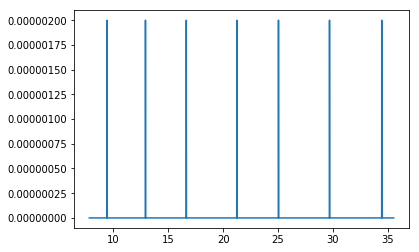

In [3]:
# CHOOSE FILE NAME

#file_name = "sound_10_mono"  # sound file, bleep every 3 sec, 10 minutes
#file_name = "sound_3"        # sound file, bleep every 3 sec, 10 minutes
#file_name = "sound_10_min"   # sound file, bleep every 3 sec, 10 minutes

#file_name = "left_right_hand"  # alternating left and right hand movement 
file_name = "move_left_1"  # just left hand movement, sitting still after 15 minutes. 
#file_name = "move_left_2"  # just left hand movement, no move after 4.20 

# #file_name = "blinks_1" #    recording of blinks and blanks
#  file_name = "blinks_2" #    recording of blinks and blanks
#file_name = "blinks_3" #    recording of blinks and blanks

# creating raw objects by reading in EEG data
raw_file = read(file = file_name) 

# extract Marker times points from both raw objecs: read from events channel ( MARKER_HARDWARE = channel 20 )
markers, times = read_markers(file = file_name)

#times = times*128

plt.plot(times[1000:4550], markers.T[1000:4550])

Extracting edf Parameters from data/move_left_1.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 154239  =      0.000 ...  1204.992 secs...
Ready.
304
channels =  1
samples before clean: 304
samples after clean: 304
[[ 1207     0     0]
 [ 1655     0     0]
 [ 2131     0     0]
 [ 2720     0     0]
 [ 3206     0     0]
 [ 3801     0     0]
 [ 4410     0     0]
 [ 4958     0     0]
 [ 5523     0     0]
 [ 6245     0     0]
 [ 6815     0     0]
 [ 7394     0     0]
 [ 8002     0     0]
 [ 8641     0     0]
 [ 9160     0     0]
 [ 9726     0     0]
 [10306     0     0]
 [10916     0     0]
 [11563     0     0]
 [12226     0     0]]


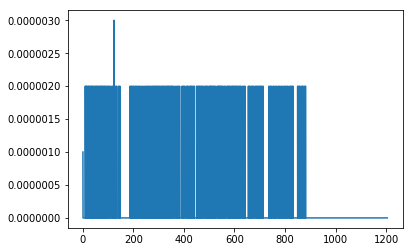

In [71]:
# CHOOSE FILE NAME

#file_name = "sound_10_mono"  # sound file, bleep every 3 sec, 10 minutes
#file_name = "sound_2"        # sound file, bleep every 3 sec, 10 minutes
#file_name = "sound_3"        # sound file, bleep every 3 sec, 10 minutes
#file_name = "sound_10_min"   # sound file, bleep every 3 sec, 10 minutes

#file_name = "left_right_hand"  # alternating left and right hand movement 
file_name = "move_left_1"  # just left hand movement, sitting still after 15 minutes. 
#file_name = "move_left_2"  # just left hand movement, no move after 4.20 


# #file_name = "blinks_1" #    recording of blinks and blanks
#  file_name = "blinks_2" #    recording of blinks and blanks
#file_name = "blinks_3" #    recording of blinks and blanks

# creating raw objects by reading in EEG data
raw_file = read(file = file_name) 

# extract Marker times points from both raw objecs: read from events channel ( MARKER_HARDWARE = channel 20 )
markers, times = read_markers(file = file_name)  
# CHOOSE CORRESPONDING FUNCTION TO CREATE EVENTS

events = create_events_move_single(markers)
#events = create_events_left_right(markers, event_id_1)

#events = create_events_sound(markers)

#events = create_events_blinks(markers)

print(len(events))

tmin = -0.5
tmax = 0.5
split_channels = True  # choose False when using 2D Convolutional Network
proj = True  # Apply SSD projection (to filter data)
make_psd = False  # convert all samples to their Power Spectrum Density
apply_savgol = False  # Filter the data using Savitzky-Golay polynomial method
print_cleaning = True
#event_id = dict(sound=0, no_sound=1)  # optional 

noise_value = 100   # determine by hand the approximate noise value by first plotting all samples

(x_train, y_train), (x_test, y_test) = create_epochs(raw_file, events = events, tmin =tmin,tmax=tmax,
                                                         proj = proj, make_psd = make_psd, 
                                                         apply_savgol= apply_savgol, 
                                                         split_channels = split_channels,
                                                         noise_value= noise_value, 
                                                         print_cleaning = print_cleaning)



print (events[:20])
plt.plot(times, markers.T)

In [31]:
(x_train, y_train) = (x_train_temp,y_train_temp)

In [74]:
# double layer perceptron 1

batch_size = 2
epochs = 25

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("Sample lenght: %i, i.e. %i seconds  " % (x_train.shape[1],(x_train.shape[1]/128)))

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(129,)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# prepare callback
histories_1 = Histories()


model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1, callbacks=[histories_1],
         validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



243 train samples
61 test samples
Sample lenght: 129, i.e. 1 seconds  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 64)                8320      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 65        
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________________________
Train on 243 samples, validate on 61 samples
Epoch 1/25
243/243 [==============================] - 1s 5ms/step - loss: 0.7815 - acc: 0.6091 - val_loss: 0.6387 - val_acc: 0.7377
Epoch 2/25
243/243 [==============================] - 1s 2ms/step - loss: 0.4136 - acc: 0.8189 - val_loss: 0.5540 - val_acc: 0.7213
Epoch 3/25
243/243 [====

In [ ]:
# double layer perceptron 1

batch_size = 8
epochs = 20

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("Sample lenght: %i, i.e. %i seconds  " % (x_train.shape[1],(x_train.shape[1]/128)))

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(129,)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# prepare callback
histories_1 = Histories()


model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1, callbacks=[histories_1],
         validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# double layer perceptron 2

batch_size = 8
epochs = 20

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("Sample lenght: %i, i.e. %i seconds  " % (x_train.shape[1],(x_train.shape[1]/128)))

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(129,)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# prepare callback
histories_2 = Histories()


model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1, callbacks=[histories_2],
         validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# double layer perceptron 3

batch_size = 8
epochs = 20

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("Sample lenght: %i, i.e. %i seconds  " % (x_train.shape[1],(x_train.shape[1]/128)))

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(129,)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# prepare callback
histories_2 = Histories()


model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1, callbacks=[histories_2],
         validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

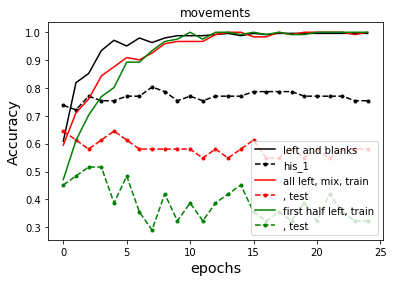

In [75]:
plt.plot(histories_1.acc, color = 'black', label = 'left and blanks')
plt.plot(histories_1.val_acc, color = 'black', label = 'his_1', marker ='.', linestyle = '--')

plt.plot(histories_2.acc, color = 'red', label = 'all left, mix, train')
plt.plot(histories_2.val_acc, color = 'red', label = ', test', marker ='.', linestyle = '--')

plt.plot(histories_3.acc, color = 'green', label = 'first half left, train')
plt.plot(histories_3.val_acc, color = 'green', label = ', test', marker = '.', linestyle = '--')

#plt.plot(histories_4.acc, color = 'blue', label = 'first half left, train')
#plt.plot(histories_4.val_acc, color = 'blue', label = ', test', marker = '.', linestyle = '--')

plt.title('movements')
plt.xlabel("epochs", fontsize = 'x-large')
plt.ylabel("Accuracy", fontsize = 'x-large')

plt.legend(loc='lower right')#, fontsize = 'x-large')



In [79]:
print(x_train[150])

[ 0.89378704  0.30508258  1.0965277   1.27555416  0.81427391  0.67001893
  1.3030131   1.32712487 -0.18131569 -1.47301989 -0.88973034 -0.00475062
 -0.49567415 -0.66280341  1.36847748  3.34367858  0.9968334  -2.27028523
 -0.5805629   1.28780651 -0.22167954 -1.48697051 -0.76348082  0.06369961
  0.43935287  0.46653205  0.08080149  0.43449511  0.7042983   0.25854313
  1.1511406   2.77543482  2.30028341  0.57346563  0.38831962  0.91263396
  0.54589833  0.57796748  0.69541701 -0.40497385 -1.78780365 -1.42964646
 -0.42373962 -0.92828576 -0.84036261  0.53742673  1.35943449  0.47230359
 -2.04084194 -3.68768196 -2.82710393 -1.08413272 -1.09179375 -1.66535047
 -0.38301507  0.52929863 -0.50293032 -1.32227089 -0.72369437 -0.41363774
 -0.26649992  0.84570912  1.36744255  0.06434317 -1.37238184 -0.49954876
  0.91215285  0.00373368 -1.1444389  -1.20292592 -0.06530786  1.08294068
 -0.13212186 -1.22397658  0.55545393  2.36767537  2.18002302  1.37195608
  0.13337543 -0.96727974 -0.84268926  0.04759394  0

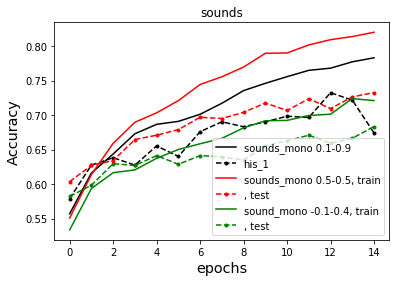

In [33]:
plt.plot(histories_1.acc, color = 'black', label = 'sounds_mono 0.1-0.9')
plt.plot(histories_1.val_acc, color = 'black', label = 'his_1', marker ='.', linestyle = '--')

plt.plot(histories_2.acc, color = 'red', label = 'sounds_mono 0.5-0.5, train')
plt.plot(histories_2.val_acc, color = 'red', label = ', test', marker ='.', linestyle = '--')

plt.plot(histories_3.acc, color = 'green', label = 'sound_mono -0.1-0.4, train')
plt.plot(histories_3.val_acc, color = 'green', label = ', test', marker = '.', linestyle = '--')

plt.title('sounds')
plt.xlabel("epochs", fontsize = 'x-large')
plt.ylabel("Accuracy", fontsize = 'x-large')

plt.legend(loc='lower right')#, fontsize = 'x-large')




In [273]:
# function that gives the total accuracy on the test-set, by first computing the confusion matrix
# of every individual channel over the test-set. From the confusion matrix the probability that a sample  
# represents an event is calculated for the 14 individual predictions of the channels. From these 14
# probabilities the total likelyhood that an event occured at the time instance the 14 samples
# are taken from. If the likelyhood is > 50 %, an event is predicted. The predictions for all the timepoints
# in the test-set are compared with the labels of the test-set. This gives the total accuracy and the final 
# confusion matrix. 

channels = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4']

show_matrix = True
conf_matrix_list, certainty_events, models_list, train_result, test_result = make_conf_matrix(channels= channels,
                                                                                     events= events, 
                                                                                     show_matrix = show_matrix)

channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.8833333412806194


,0,1
0,27,4
1,3,26


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.7833333253860474


,0,1
0,24,7
1,6,23


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.900000007947286


,0,1
0,28,4
1,2,26


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.75


,0,1
0,24,9
1,6,21


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.8166666626930237


,0,1
0,25,6
1,5,24


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.8166666785875957


,0,1
0,23,4
1,7,26


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.850000003973643


,0,1
0,25,4
1,5,26


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.7166666587193807


,0,1
0,21,8
1,9,22


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.799999992052714


,0,1
0,26,8
1,4,22


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.6333333452542623


,0,1
0,19,11
1,11,19


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.8166666706403096


,0,1
0,25,6
1,5,24


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.7499999920527141


,0,1
0,23,8
1,7,22


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.7833333373069763


,0,1
0,25,8
1,5,22


channels =  1
Labels to predict before equal: 61
Labels to predict after equal: 60
Test accuracy: 0.75


,0,1
0,22,7
1,8,23


samples before clean: 304
samples after clean: 303
shape x_test (61, 14, 129)
shape y_test (61, 14, 129)
Labels to predict: 61
Confusion matrix over test-set:


,0,1
0,27,2
1,3,29


Accuracy over test set:  0.918032786885


In [199]:
# function that gives the accuracy of the prediction made using the confusion matrices of the
# individual channels. The function gives the list of where to find events and plots this

# this is for sound file: 

time_zero = 3608
time_end = time_zero+(10*384)   # say 20 bleeps
events_time = []
    
for time in np.arange(time_zero, time_end, 10): 
    events_time.append(time)
    
class_nb_list = np.tile(0, len(events_time)) # list to store the class number
previous_marker_value = np.zeros(len(events_time)) # list with previous id, required to create Epoch object
events = np.column_stack((events_time, previous_marker_value, class_nb_list))
events = events.astype(int)    


## Events laden

Alvorens jadiejadie moeten de event worden ingeladen. Belangrijk hierbij is ...


Extracting edf Parameters from data/move_left_1.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 154239  =      0.000 ...  1204.992 secs...
Ready.
1207
240
240 matching events found
0 projection items activated
Loading data for 240 events and 129 original time points ...
0 bad epochs dropped
shape x_test (240, 14, 129)
Extracting edf Parameters from data/move_left_1.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 154239  =      0.000 ...  1204.992 secs...
Ready.


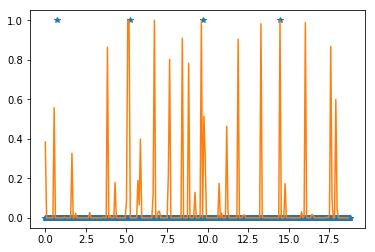

In [336]:
# Create event list for movements: 

#file_name = "move_left_1" 

events_time = []  # list to store the time of the events

markers, times = read_markers(file = file_name)

markers = (markers.ravel())*(1000000) # flatten and rescale marker file
    
events_time = []  # list to store the time of the events
event_id_1 = 2  

time_zero = 0 
for i in np.arange(0,len(markers)):
    if (markers[i]) == event_id_1:
        time_zero = i
        break

print(time_zero) 

time_zero = 6150 
time_end = 8550
for time in np.arange(time_zero, time_end, 10): 
    events_time.append(time)
    
class_nb_list = np.tile(0, len(events_time)) # list to store the class number
previous_marker_value = np.zeros(len(events_time)) # list with previous id, required to create Epoch object
events_stream = np.column_stack((events_time, previous_marker_value, class_nb_list))
events_stream = events_stream.astype(int)    

events_time = np.array(events_time)
events_time = (events_time-time_zero)/128



print (len(events_stream))

found_events = find_events(conf_matrix_list, models_list, events_stream)

markers, times = read_markers(file = file_name)
markers = ((markers.ravel())*(1000000))/2 # flatten and rescale marker file

times = times-(6150/128)


plt.plot(times[6150:8550], markers.T[6150:8550],  marker ='*', linestyle = ' ')  

plt.plot(events_time, found_events)

555
555 matching events found
0 projection items activated
Loading data for 555 events and 129 original time points ...
7 bad epochs dropped
shape x_test (548, 14, 129)
Extracting edf Parameters from data/move_left_2.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 50815  =      0.000 ...   396.992 secs...
Ready.


ValueError: x and y must have same first dimension, but have shapes (555,) and (548,)

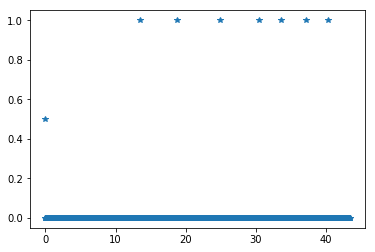

In [333]:
# now read in diferent data set, that is not trained on!

file_name = "move_left_1" 
events_time = []
time_zero = 1000 
time_end = 4550
for time in np.arange(time_zero, time_end, 5): 
    events_time.append(time)
    
class_nb_list = np.tile(0, len(events_time)) # list to store the class number
previous_marker_value = np.zeros(len(events_time)) # list with previous id, required to create Epoch object
events_stream = np.column_stack((events_time, previous_marker_value, class_nb_list))
events_stream = events_stream.astype(int)    

events_time = np.array(events_time)
events_time = (events_time-time_zero)/128



print (len(events_stream))

found_events = find_events(conf_matrix_list, models_list, events_stream)

markers, times = read_markers(file = file_name)
markers = ((markers.ravel())*(1000000))/2 # flatten and rescale marker file
#times = times-(1150/128)



plt.plot(times[:4550], markers.T[:4550],  marker ='*', linestyle = ' ')

plt.plot(events_time, found_events)


/anaconda3/envs/EEGProject/lib/python2.7/site-packages/mne/viz/raw.py:719: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


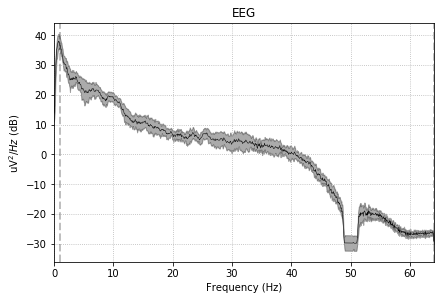

fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.


<ipython-input-163-b1a1be3f0d74>:2: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  raw_file.filter(5,40)
/anaconda3/envs/EEGProject/lib/python2.7/site-packages/mne/viz/raw.py:719: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


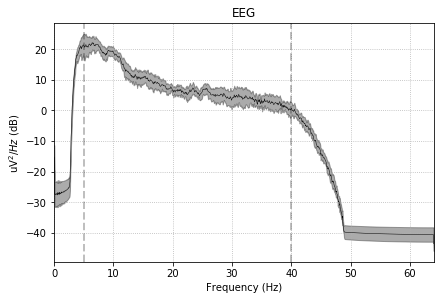

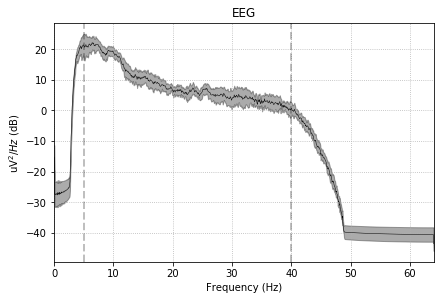

In [163]:
raw_file.plot_psd()
raw_file.filter(5,40)
raw_file.plot_psd()


243
61


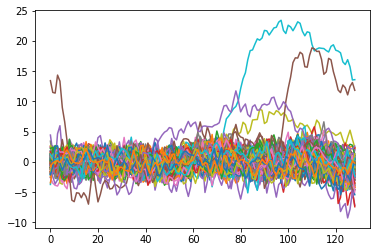

In [80]:
# print all no_sounds

for i in np.arange(len(y_train)):
    if y_train[i] == 0: 
        plt.plot(x_train[i])
        
for i in np.arange(len(y_test)):
    if y_test[i] == 0: 
        plt.plot(x_test[i])

print(len(y_train))
print(len(y_test))
#plt.title("First 5 'blanks' of channel 'F7'")
#plt.xlabel("Time (s.freq)")
#plt.ylabel("Electric potential (uV)")



243
61
121


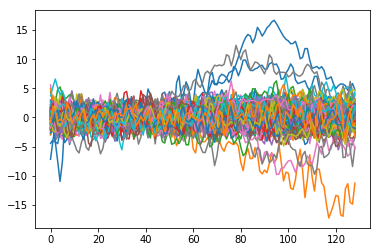

In [81]:
x = 0
for i in np.arange(len(y_train)):
    if y_train[i] == 1: 
        plt.plot(x_train[i])
        x = x+1
        
for i in np.arange(len(y_test)):
    if y_test[i] == 1: 
        plt.plot(x_test[i])
print(len(y_train))
print(len(y_test))
print (x)

104 matching events found
0 projection items activated
Loading data for 104 events and 129 original time points ...
0 bad epochs dropped


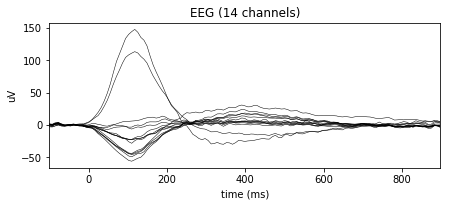

102 matching events found
0 projection items activated
Loading data for 102 events and 129 original time points ...
0 bad epochs dropped


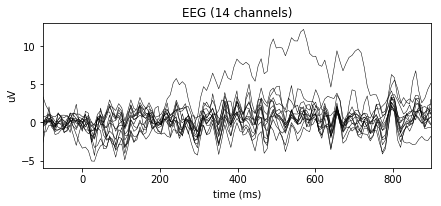

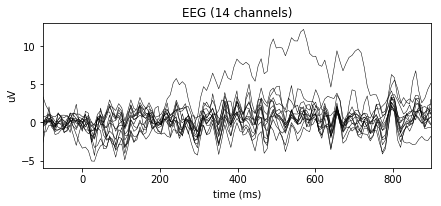

In [385]:

blinks = mne.Epochs(raw_file, events=events, event_id = 0, tmin=-0.1,
                                tmax=0.9, preload = True)





evoked = blinks.average()
evoked.plot()

no_blinks = mne.Epochs(raw_file, events=events, event_id = 1, tmin=-0.1,
                                tmax=0.9, preload = True)


evoked = no_blinks.average()
evoked.plot()


199 matching events found
0 projection items activated
0 bad epochs dropped


RuntimeError: No digitization points found.

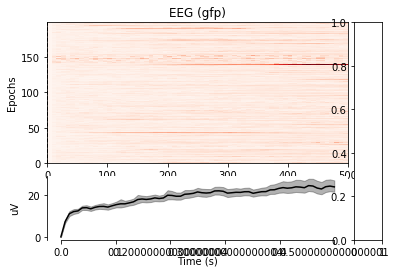

In [10]:
blinks.plot_image()

199 matching events found
0 projection items activated
0 bad epochs dropped


RuntimeError: No digitization points found.

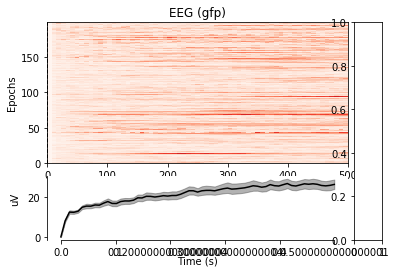

In [11]:
no_blinks.plot_image()

In [ ]:
# in case events from several files should be but together in one training set: 

x_train = np.row_stack((x_train_1,x_train_2))
x_test = np.row_stack((x_test_1,x_test_2))
y_train = np.concatenate((y_train_1,y_train_2))
y_test = np.concatenate((y_test_1,y_test_2))

In [404]:
# train every channel individualy 

channels = ['AF3','F7','F3','FC5'] #,'T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4',]
pick = []
train_accuracy_1 = []
test_accuracy_1 = []
print(len(channels))

batch_size = 4
epochs = 2

for pick in np.arange(len(channels)):
   # print(pick)

    channel = channels[pick]
    
    channel = ['%s'%(channel)]
    raw = read(file = file_name) 

    temp_file = raw.pick_channels(channel)

    (x_train, y_train), (x_test, y_test) = create_epochs(temp_file, events = events, tmin =tmin,tmax=tmax,
                                                         proj = proj, make_psd = make_psd, 
                                                         apply_savgol= apply_savgol, 
                                                         split_channels = split_channels,
                                                         noise_value= noise_value, 
                                                         print_cleaning = print_cleaning)



    # double layer perceptron

    
  #  x_train = x_train.reshape(44,129)
  #  x_test = x_test.reshape(12,129)
  #  print(x_train.shape[0], 'train samples')
  #  print (len(y_train))
  #  print(x_test.shape[0], 'test samples')
  #  print (len(y_test))
    #print("Sample lenght: %i, i.e. %i seconds  " % (x_train.shape[1],(x_train.shape[1]/128)))

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(129,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))



   # model.summary()

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # prepare callback
    histories_2 = Histories()


    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0, callbacks=[histories_2],
             validation_data=(x_test, y_test))
    
    train_accuracy_1.append(histories_2.acc)
    test_accuracy_1.append(histories_2.val_acc)
    y_predict = model.predict_classes(x_test)
  #  conf_matrix = confusion_matrix(y_predict, y_test)
  #  dispMat(conf_matrix)

    score = model.evaluate(x_test, y_test, verbose=0)
   # print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    
    #print('Test accuracy:', score[1])
  #  test_accuracy.append(score[1])
    

print('klaar')


4
channels =  1
samples before clean: 206
samples after clean: 206
Test accuracy: 0.7857142800376529
channels =  1
samples before clean: 206
samples after clean: 206
Test accuracy: 0.9285714228947958
channels =  1
samples before clean: 206
samples after clean: 206
Test accuracy: 1.0
channels =  1
samples before clean: 206
samples after clean: 206
Test accuracy: 0.9761904761904762
klaar


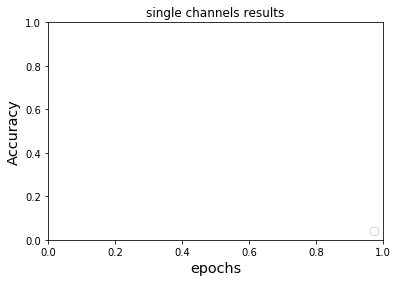

In [405]:
for results in train_accuracy_1:
    plt.plot(results, color = 'black', label = 'train')

for results in test_accuracy_1:   
    plt.plot(results, color = 'red', label = 'test', marker ='.', linestyle = '--')


plt.title('single channels results')
plt.xlabel("epochs", fontsize = 'x-large')
plt.ylabel("Accuracy", fontsize = 'x-large')

plt.legend(loc='lower right')#, fontsize = 'x-large')




In [ ]:
for results in train_accuracy_2:
    plt.plot(results, color = 'black', label = 'train')

for results in test_accuracy_2:   
    plt.plot(results, color = 'red', label = 'test', marker ='.', linestyle = '--')


plt.title('single channels results')
plt.xlabel("epochs", fontsize = 'x-large')
plt.ylabel("Accuracy", fontsize = 'x-large')

plt.legend(loc='lower right')#, fontsize = 'x-large')




In [236]:
for counter, value in enumerate(train_accuracy):
    print(counter, value)

0 0.9588477366255144
1 0.9753086419753086
2 0.9711934156378601
3 0.9629629629629629
4 0.8806584362139918
5 0.9753086419753086
6 0.9876543209876543
7 0.9506172839506173
8 0.9711934156378601
9 0.9629629629629629
10 0.9835390946502057
11 0.9629629629629629
12 0.8884297520661157
13 0.9465020576131687


In [243]:
for counter, value in enumerate(train_accuracy):
    print(counter, value)

0 0.9547325102880658
1 0.9753086419753086
2 0.9711934156378601
3 0.9629629629629629


In [244]:
for counter, value in enumerate(test_accuracy):
    print(counter, value)

0 0.8852459035935949
1 0.836065586473121
2 0.9180327780911179
3 0.8196721331017917


In [79]:
accuracy = np.array(test_accuracy)
sd = np.std(accuracy)

mean = np.mean(accuracy)

index = []
for i in np.arange(len(accuracy)):
    print(mean - accuracy[i])
    if ((accuracy[i]) - mean ) < 0 :
        index.append(i)
        
print (index)

channels = np.delete(channels, index)
channels



0.0008928571428571397
0.03839285714285712
0.0008928571428571397
0.03839285714285712
-0.024107142857142883
0.0758928571428571
0.0008928571428571397
0.013392857142857095
-0.024107142857142883
0.025892857142857106
-0.049107142857142905
-0.011607142857142927
-0.06160714285714286
-0.024107142857142883
[0, 1, 2, 3, 5, 6, 7, 9]


array(['T7', 'P8', 'FC6', 'F4', 'F8', 'AF4'], dtype='|S3')

In [84]:
print(np.shape(x_train))
print(np.shape(y_train))

print(np.shape(x_test))
print(np.shape(y_test))

x_train = x_train.reshape(318,6,129,1)
x_test = x_test.reshape(80,6,129,1)

(318, 6, 129)
(318,)
(80, 6, 129)
(80,)


In [93]:
# 2D convolutional network
batch_size = 2
epochs = 15

model = Sequential()
model.add(Conv2D(4, kernel_size=(6,20),
                 activation='relu',
                 input_shape=(6,129,1)))
model.add(Dropout(2.5))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(2.0))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

histories_3 = Histories()
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,callbacks=[histories_3],validation_data=(x_test, y_test) )




score = model.evaluate(x_test, y_test, verbose=0)
y_predict = model.predict_classes(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 318 samples, validate on 80 samples
Epoch 1/15
318/318 [==============================] - 5s 14ms/step - loss: 0.7332 - acc: 0.4906 - val_loss: 0.6977 - val_acc: 0.4500
Epoch 2/15
318/318 [==============================] - 1s 4ms/step - loss: 0.6830 - acc: 0.6195 - val_loss: 0.7165 - val_acc: 0.4875
Epoch 3/15
318/318 [==============================] - 1s 4ms/step - loss: 0.6710 - acc: 0.5975 - val_loss: 0.7187 - val_acc: 0.4875
Epoch 4/15
318/318 [==============================] - 1s 3ms/step - loss: 0.6380 - acc: 0.6509 - val_loss: 0.7500 - val_acc: 0.5000
Epoch 5/15
318/318 [==============================] - 1s 4ms/step - loss: 0.6159 - acc: 0.6730 - val_loss: 0.7310 - val_acc: 0.5250
Epoch 6/15
318/318 [==============================] - 1s 4ms/step - loss: 0.5882 - acc: 0.6950 - val_loss: 0.7514 - val_acc: 0.4750
Epoch 7/15
318/318 [==============================] - 1s 4ms/step - loss: 0.5903 - acc: 0.7013 - val_loss: 0.7595 - val_acc: 0.5250
Epoch 8/15
318/318 [==========

In [225]:
# double layer perceptron 1

batch_size = 8
epochs = 20

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("Sample lenght: %i, i.e. %i seconds  " % (x_train.shape[1],(x_train.shape[1]/128)))

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(129,)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# prepare callback
histories_1 = Histories()


model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1, callbacks=[histories_1],
         validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# double layer perceptron 2

batch_size = 8
epochs = 20

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("Sample lenght: %i, i.e. %i seconds  " % (x_train.shape[1],(x_train.shape[1]/128)))

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(129,)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# prepare callback
histories_1 = Histories()


model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1, callbacks=[histories_1],
         validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3404 train samples
851 test samples
Sample lenght: 129, i.e. 1 seconds  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_371 (Dense)            (None, 64)                8320      
_________________________________________________________________
dropout_186 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_372 (Dense)            (None, 1)                 65        
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________________________
Train on 3404 samples, validate on 851 samples
Epoch 1/10
3404/3404 [==============================] - 16s 5ms/step - loss: 0.6532 - acc: 0.7221 - val_loss: 0.6696 - val_acc: 0.7485
Epoch 2/10
3404/3404 [==============================] - 4s 1ms/step - loss: 0.4926 - acc: 0.8041 - val_loss: 0.4367 - val_acc: 0.8355
Epoch 3/10
3404

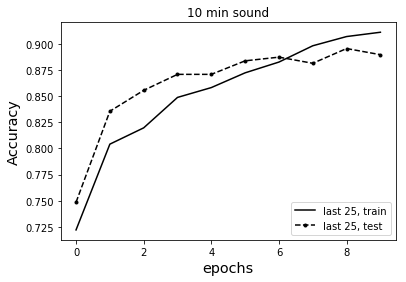

In [231]:

#plt.plot(histories_3.acc, color = 'green', label = 'Thomas sound, train')
#plt.plot(histories_3.val_acc, color = 'green', label = 'Thomas sound, test', marker ='.', linestyle = '--')

#plt.plot(histories_4.acc, color = 'orange', label = 'Dummy sound, train')
#plt.plot(histories_4.val_acc, color = 'purple', label = 'Dummy sound, test', marker ='.', linestyle = '--')

#plt.plot(histories_2.acc, color = 'red', label = 'first 25, train')
#plt.plot(histories_2.val_acc, color = 'red', label = 'first, test', marker = '.', linestyle = '--')

plt.plot(histories_1.acc, color = 'black', label = 'last 25, train')
plt.plot(histories_1.val_acc, color = 'black', label = 'last 25, test', marker ='.', linestyle = '--')




#plt.axis(xmin = 0, xmax = 50)
plt.title('10 min sound')
plt.xlabel("epochs", fontsize = 'x-large')
plt.ylabel("Accuracy", fontsize = 'x-large')

plt.legend(loc='lower right')#, fontsize = 'x-large')



Text(0,0.5,'Accuracy')

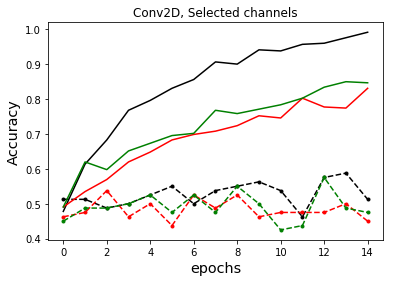

In [94]:
plt.plot(histories_1.acc, color = 'black', label = 'split')
plt.plot(histories_1.val_acc, color = 'black', label = 'test on first 50', marker ='.', linestyle = '--')

plt.plot(histories_2.acc, color = 'red', label = 'no split shuffle, train')
plt.plot(histories_2.val_acc, color = 'red', label = 'test on last 50, test', marker ='.', linestyle = '--')

plt.plot(histories_3.acc, color = 'green', label = 'no split no shuffle, train')
plt.plot(histories_3.val_acc, color = 'green', label = 'last 50, test', marker = '.', linestyle = '--')

plt.title('Conv2D, Selected channels')
plt.xlabel("epochs", fontsize = 'x-large')
plt.ylabel("Accuracy", fontsize = 'x-large')

#plt.legend(loc='lower right', fontsize = 'x-large')



In [393]:
histories = Histories()

print(histories)

i = 8 

histories.name = "histories_%i"%i

print(histories_8)

NameError: name 'histories_8' is not defined

In [217]:
x = np.arange(10)
print (x)
x = list(x)
print (x)
np.random.shuffle(x)
x

[0 1 2 3 4 5 6 7 8 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


[8, 1, 7, 5, 4, 6, 0, 9, 3, 2]